<a href="https://colab.research.google.com/github/haridas-das/dengue-epidemic/blob/main/final_2024_summer_data_science_boot_camp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Install and import packages
!pip install openmeteo-requests
!pip install requests-cache retry-requests

import pandas as pd
import os

## Access Google Drive for dataset
from google.colab import drive
drive.mount('/content/drive')

#path = '/content/drive/My Drive/data-science-may-2024/data 2008 - 2023'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import seaborn as sns

In [ ]:
!pip install squarify

In [ ]:
pip install keras


In [ ]:
!pip install plotly_express


In [ ]:
pip install --upgrade tensorflow


In [ ]:
pip install sklearn-keras

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
from keras.layers import TimeDistributed
from keras.layers import Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from keras.datasets import reuters
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, SimpleRNN, Activation
from keras import optimizers
#from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
#from keras.layers.convolutional import Conv1D
#from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Special plot that makes the figure bigger
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')

In [ ]:
# tf.random.set_seed(123)
SEED = 1000

# Data prepossing

In [ ]:
# /content/drive/MyDrive/Colab Notebook/Colab Notebook/Erdos Institute Summer 2024/data-science-may-2024/data 2008 - 2023/2008_2023_Final_BD_Whole_DengueAndClimateBangladesh.csv
path = '/content/drive/MyDrive/Colab Notebook/Colab Notebook/Erdos Institute Summer 2024/data-science-may-2024/data 2008 - 2023'


In [ ]:
## Load population data downloaded and unzipped from https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2022_TotalPopulationBySex.zip
file_pop = 'WPP2022_TotalPopulationBySex.csv'
df_pop = pd.read_csv(os.path.join(path, file_pop), low_memory=False)
# Filter data for Bangladesh till 2021, as data till 2021 is historic and data beyond 2021 is projection. Population is in thousands
df_pop = df_pop[(df_pop['Location'] == 'Bangladesh') & (df_pop['Variant'] == 'Medium') & (df_pop['Time'] <= 2023)].rename(columns={'Time':'year', 'PopTotal':'pop'})[['year','pop']]
df_pop

year         pop
322092  1950   39728.535
322093  1951   40548.590
322094  1952   41426.885
322095  1953   42329.279
322096  1954   43282.032
...      ...         ...
322161  2019  165516.222
322162  2020  167420.951
322163  2021  169356.251
322164  2022  171186.372
322165  2023  172954.319

[74 rows x 2 columns]

In [ ]:
df_pop['pop'] *= 1000
df_pop

year          pop
322092  1950   39728535.0
322093  1951   40548590.0
322094  1952   41426885.0
322095  1953   42329279.0
322096  1954   43282032.0
...      ...          ...
322161  2019  165516222.0
322162  2020  167420951.0
322163  2021  169356251.0
322164  2022  171186372.0
322165  2023  172954319.0

[74 rows x 2 columns]

In [ ]:


## Load reported dengue cases data downloaded and manually recorded from https://old.dghs.gov.bd/index.php/bd/home/5200-daily-dengue-status-report
file_case = '2008_2023_Final_BD_Whole_DengueAndClimateBangladesh.csv'
df_case = pd.read_csv(os.path.join(path, file_case)).rename(columns={'YEAR' : 'year', 'MONTH' : 'month', 'DENGUE IN' : 'case'})[['year','month','case']]

## Find data for common years
df_pop_case = pd.merge(df_pop, df_case, how='inner', on=['year'])
df_pop_case

year          pop  month   case
0    2008  145421318.0      1      0
1    2008  145421318.0      2      0
2    2008  145421318.0      3      0
3    2008  145421318.0      4      0
4    2008  145421318.0      5      0
..    ...          ...    ...    ...
187  2023  172954319.0      8  71976
188  2023  172954319.0      9  79598
189  2023  172954319.0     10  67769
190  2023  172954319.0     11  40716
191  2023  172954319.0     12   9288

[192 rows x 4 columns]

In [ ]:
## Load weather data downloaded or retrieved from https://open-meteo.com/en/docs/historical-weather-api
# if os.path.isfile(os.path.join(path, 'weather.csv')): # Use downloaded data
#   df_weather = pd.read_csv(os.path.join(path, 'weather.csv'))
# else: # Download data
import openmeteo_requests

import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
"latitude": 24,
"longitude": 90,
"start_date": "1940-01-01",
"end_date": "2024-05-22",
"hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "precipitation", "rain", "soil_temperature_0_to_7cm", "soil_temperature_7_to_28cm", "soil_temperature_28_to_100cm", "soil_temperature_100_to_255cm", "soil_moisture_0_to_7cm", "soil_moisture_7_to_28cm", "soil_moisture_28_to_100cm", "soil_moisture_100_to_255cm"],
"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()
hourly_rain = hourly.Variables(5).ValuesAsNumpy()
hourly_soil_temperature_0_to_7cm = hourly.Variables(6).ValuesAsNumpy()
hourly_soil_temperature_7_to_28cm = hourly.Variables(7).ValuesAsNumpy()
hourly_soil_temperature_28_to_100cm = hourly.Variables(8).ValuesAsNumpy()
hourly_soil_temperature_100_to_255cm = hourly.Variables(9).ValuesAsNumpy()
hourly_soil_moisture_0_to_7cm = hourly.Variables(10).ValuesAsNumpy()
hourly_soil_moisture_7_to_28cm = hourly.Variables(11).ValuesAsNumpy()
hourly_soil_moisture_28_to_100cm = hourly.Variables(12).ValuesAsNumpy()
hourly_soil_moisture_100_to_255cm = hourly.Variables(13).ValuesAsNumpy()


hourly_data = {"date": pd.date_range(
start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
freq = pd.Timedelta(seconds = hourly.Interval()),
inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["soil_temperature_0_to_7cm"] = hourly_soil_temperature_0_to_7cm
hourly_data["soil_temperature_7_to_28cm"] = hourly_soil_temperature_7_to_28cm
hourly_data["soil_temperature_28_to_100cm"] = hourly_soil_temperature_28_to_100cm
hourly_data["soil_temperature_100_to_255cm"] = hourly_soil_temperature_100_to_255cm
hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm
hourly_data["soil_moisture_7_to_28cm"] = hourly_soil_moisture_7_to_28cm
hourly_data["soil_moisture_28_to_100cm"] = hourly_soil_moisture_28_to_100cm
hourly_data["soil_moisture_100_to_255cm"] = hourly_soil_moisture_100_to_255cm

df_weather = pd.DataFrame(data = hourly_data)
df_weather.to_csv(os.path.join(path, 'weather.csv'), sep=',', encoding='utf-8', index=False)
# display(df_weather)

Coordinates 24.007028579711914°N 90.0°E
Elevation 11.0 m asl
Timezone b'Asia/Dhaka' b'+06'
Timezone difference to GMT+0 21600 s


In [ ]:
 df_weather.tail(5)

date  temperature_2m  relative_humidity_2m  \
739771 2024-05-22 13:00:00+00:00       25.299999             91.968750   
739772 2024-05-22 14:00:00+00:00       25.700001             93.939247   
739773 2024-05-22 15:00:00+00:00       25.549999             93.092804   
739774 2024-05-22 16:00:00+00:00       25.750000             95.354050   
739775 2024-05-22 17:00:00+00:00       25.799999             92.827156   

        dew_point_2m  apparent_temperature  precipitation  rain  \
739771     23.900000             30.466183            1.4   1.4   
739772     24.650000             31.664425            0.4   0.4   
739773     24.350000             31.277294            0.0   0.0   
739774     24.950001             32.290974            0.0   0.0   
739775     24.549999             31.557686            0.0   0.0   

        soil_temperature_0_to_7cm  soil_temperature_7_to_28cm  \
739771                  28.150000                   30.299999   
739772                  27.650000                   30.100000   
739773                  27.299999                   29.900000   
739774                  27.200001                   29.700001   
739775                  27.100000                   29.549999   

        soil_temperature_28_to_100cm  soil_temperature_100_to_255cm  \
739771                          29.1                      26.049999   
739772                          29.1                      26.049999   
739773                          29.1                      26.049999   
739774                          29.1                      26.100000   
739775                          29.1                      26.100000   

        soil_moisture_0_to_7cm  soil_moisture_7_to_28cm  \
739771                   0.352                    0.252   
739772                   0.355                    0.252   
739773                   0.352                    0.253   
739774                   0.350                    0.254   
739775                   0.348                    0.254   

        soil_moisture_28_to_100cm  soil_moisture_100_to_255cm  
739771                      0.176                       0.332  
739772                      0.176                       0.332  
739773                      0.176                       0.332  
739774                      0.176                       0.332  
739775                      0.176                       0.332

In [ ]:
## Split year and month. Accumulate data for each month by averaging
df_weather['year'] = pd.DatetimeIndex(df_weather['date']).year
df_weather['month'] = pd.DatetimeIndex(df_weather['date']).month
df_weather = df_weather.drop('date', axis=1)
df_weather_grouped = df_weather.groupby(['year','month'], as_index=False).mean()

In [ ]:
## Find data for common years and months
df = pd.merge(df_pop_case, df_weather_grouped, how='inner', on=['year','month'])

## Compute classification output variable: epidemic year from dengue cases and population
pop_reference = 1e6
thres_epidemic = 10
df['epidemic'] = df.apply(lambda row: 1 if row['case'] / row['pop'] * pop_reference >= thres_epidemic else 0, axis=1)
df.to_csv(os.path.join(path, 're_epidemic.csv'), sep=',', encoding='utf-8', index=False)

In [ ]:
df

year          pop  month   case  temperature_2m  relative_humidity_2m  \
0    2008  145421318.0      1      0       18.816063             71.920219   
1    2008  145421318.0      2      0       19.580603             67.713432   
2    2008  145421318.0      3      0       26.113911             69.925537   
3    2008  145421318.0      4      0       28.868820             68.275215   
4    2008  145421318.0      5      0       29.157797             78.510475   
..    ...          ...    ...    ...             ...                   ...   
187  2023  172954319.0      8  71976       28.773655             84.193726   
188  2023  172954319.0      9  79598       28.616737             84.860321   
189  2023  172954319.0     10  67769       26.470228             80.579788   
190  2023  172954319.0     11  40716       23.494862             74.590225   
191  2023  172954319.0     12   9288       19.717943             79.721024   

     dew_point_2m  apparent_temperature  precipitation      rain  \
0       13.050537             18.846455       0.059677  0.059677   
1       12.699282             19.758987       0.019540  0.019540   
2       19.510080             28.911985       0.043817  0.043817   
3       21.753263             32.684200       0.083194  0.083194   
4       24.706787             34.700409       0.231855  0.231855   
..            ...                   ...            ...       ...   
187     25.667004             34.691467       0.474597  0.474597   
188     25.664446             34.663101       0.374306  0.374306   
189     22.533937             30.832661       0.266398  0.266398   
190     18.314583             25.738976       0.017083  0.017083   
191     15.804638             20.783993       0.061694  0.061694   

     soil_temperature_0_to_7cm  soil_temperature_7_to_28cm  \
0                    20.323925                   20.743010   
1                    20.795403                   20.746624   
2                    27.472446                   26.675671   
3                    30.437639                   29.690001   
4                    30.718281                   30.445698   
..                         ...                         ...   
187                  29.797714                   29.658871   
188                  29.679790                   29.607847   
189                  27.685350                   27.797447   
190                  24.282778                   24.726112   
191                  20.466600                   21.015860   

     soil_temperature_28_to_100cm  soil_temperature_100_to_255cm  \
0                       21.932123                      24.020765   
1                       20.984770                      22.767241   
2                       24.659275                      22.777016   
3                       27.555071                      24.329166   
4                       29.321033                      26.255915   
..                            ...                            ...   
187                     29.403765                      28.652485   
188                     29.498749                      29.077501   
189                     28.310617                      28.956520   
190                     26.056042                      28.145210   
191                     22.784477                      26.275740   

     soil_moisture_0_to_7cm  soil_moisture_7_to_28cm  \
0                  0.188774                 0.196161   
1                  0.221586                 0.223101   
2                  0.189638                 0.166454   
3                  0.201497                 0.183417   
4                  0.303534                 0.260360   
..                      ...                      ...   
187                0.387253                 0.386711   
188                0.381914                 0.378585   
189                0.322681                 0.334352   
190                0.261907                 0.288050   
191                0.301503                 0.315231   

     soil_moistu

# Exploratory Data Analysis


In [ ]:
## Install and import packages
!pip install dataprep
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [ ]:
from dataprep.eda import create_report


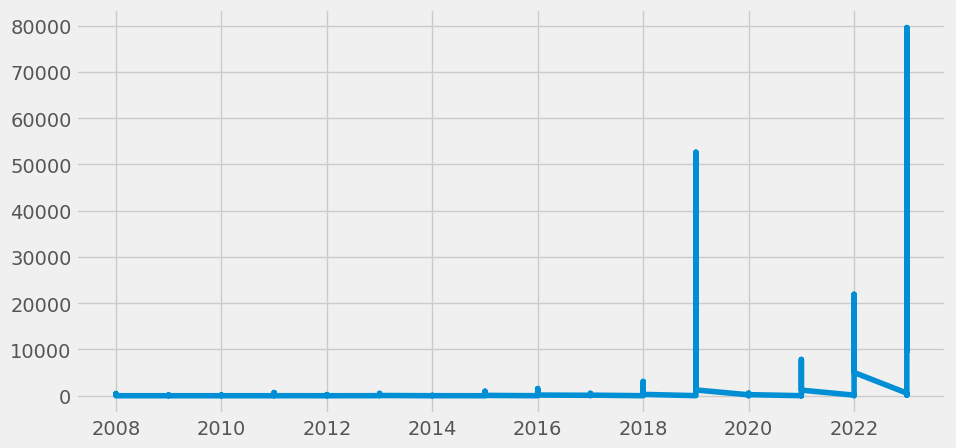

In [ ]:
plt.plot(df.year, df.case)
plt.show()

In [ ]:
# Shows locations of missing values
print(np.where(df.isna())[0])

# Shows locations of infinite values
print(np.where(df.isin([np.inf -np.inf]))[0])

# Shows locations of duplicate rows
print(np.where(df.duplicated(keep=False))[0])

[]
[]
[]


Computing apply-df9c6fc0479fac1f7106be7c732e8317:   0%|          | 0/3898 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


DataPrep Report
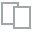
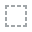
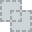
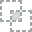
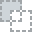
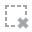
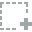
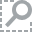
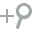
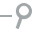
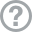
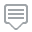
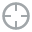
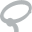
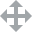
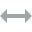
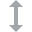
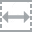
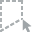
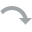
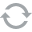
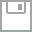
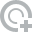
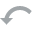
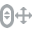
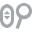
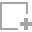
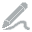
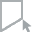
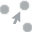
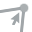
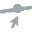

In [ ]:
# Show many results
create_report(df)

# Time series analysis

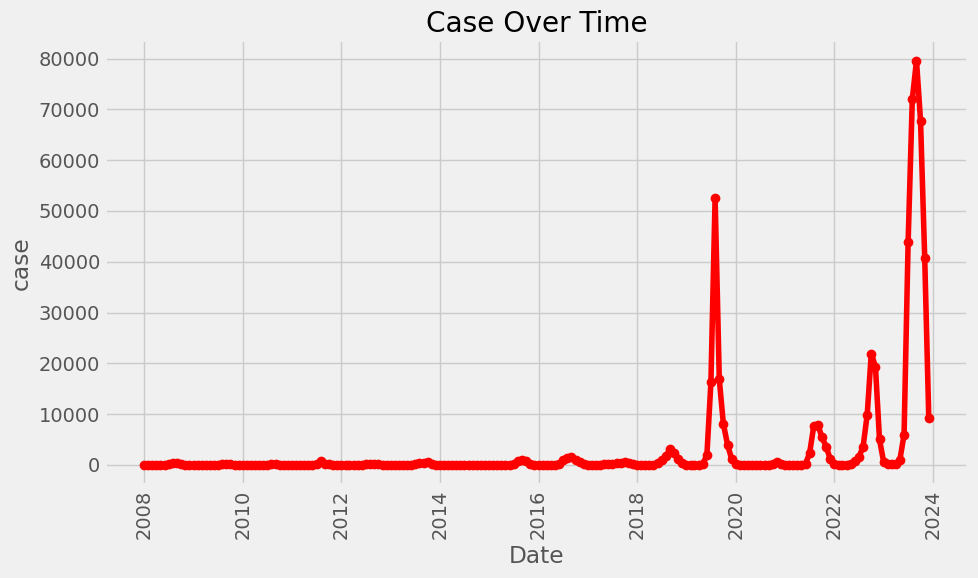

In [ ]:
# Convert 'month' and 'year' into a datetime column
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['case'], marker='o', linestyle='-',color='red')
plt.title('Case Over Time')
plt.xlabel('Date')
plt.ylabel('case')
#plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

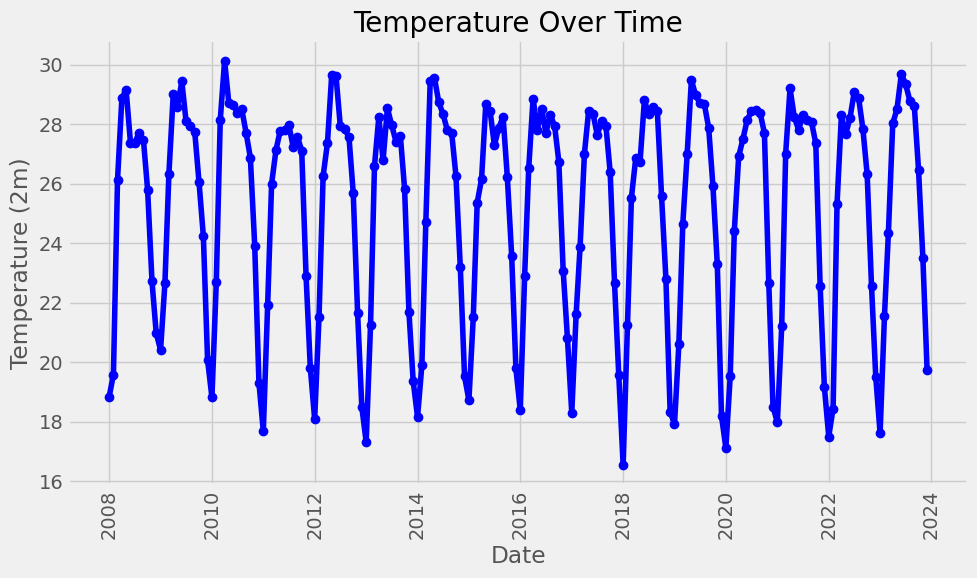

In [ ]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['temperature_2m'], marker='o', linestyle='-',color='blue')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (2m)')
#plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

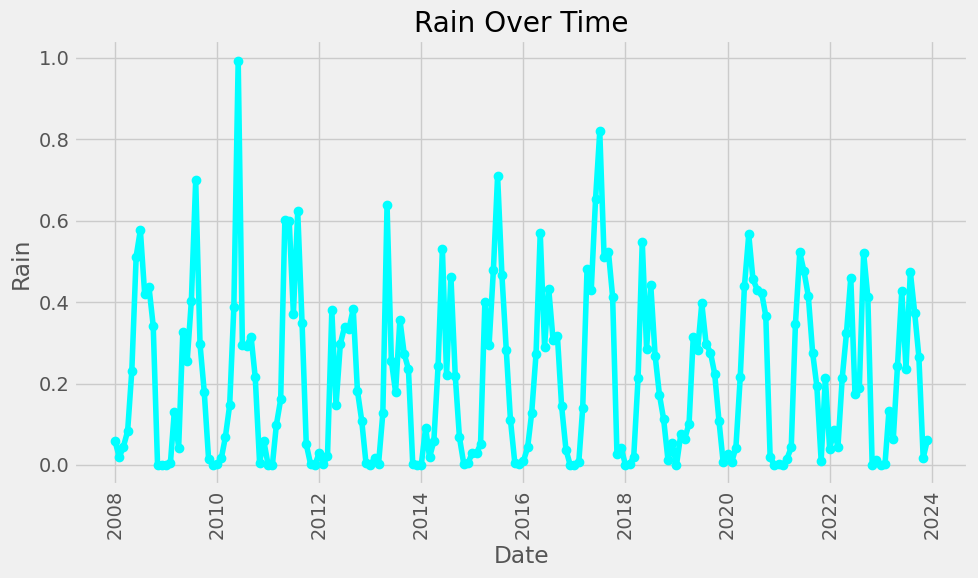

In [ ]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['rain'], marker='o', linestyle='-',color='cyan')
plt.title('Rain Over Time')
plt.xlabel('Date')
plt.ylabel('Rain')
#plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<ipython-input-142-50fe3049be67>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='month', y='temperature_2m', data=df, ci= None, color='gray', linestyle='--')


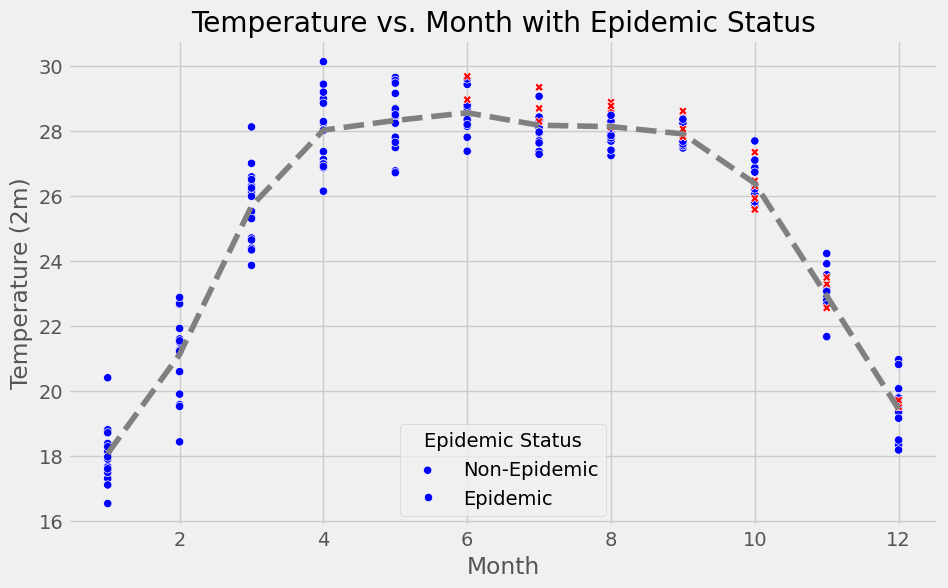

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='month', y='temperature_2m', hue='epidemic', style='epidemic', data=df, palette=['blue', 'red'])
sns.lineplot(x='month', y='temperature_2m', data=df, ci= None, color='gray', linestyle='--')

plt.title('Temperature vs. Month with Epidemic Status')
plt.xlabel('Month')
plt.ylabel('Temperature (2m)')
plt.legend(title='Epidemic Status', labels=['Non-Epidemic', 'Epidemic'])
plt.grid(True)
plt.show()


In [ ]:
df.columns

Index(['year', 'pop', 'month', 'case', 'temperature_2m',
       'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature',
       'precipitation', 'rain', 'soil_temperature_0_to_7cm',
       'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm',
       'soil_temperature_100_to_255cm', 'soil_moisture_0_to_7cm',
       'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm',
       'soil_moisture_100_to_255cm', 'epidemic', 'date'],
      dtype='object')

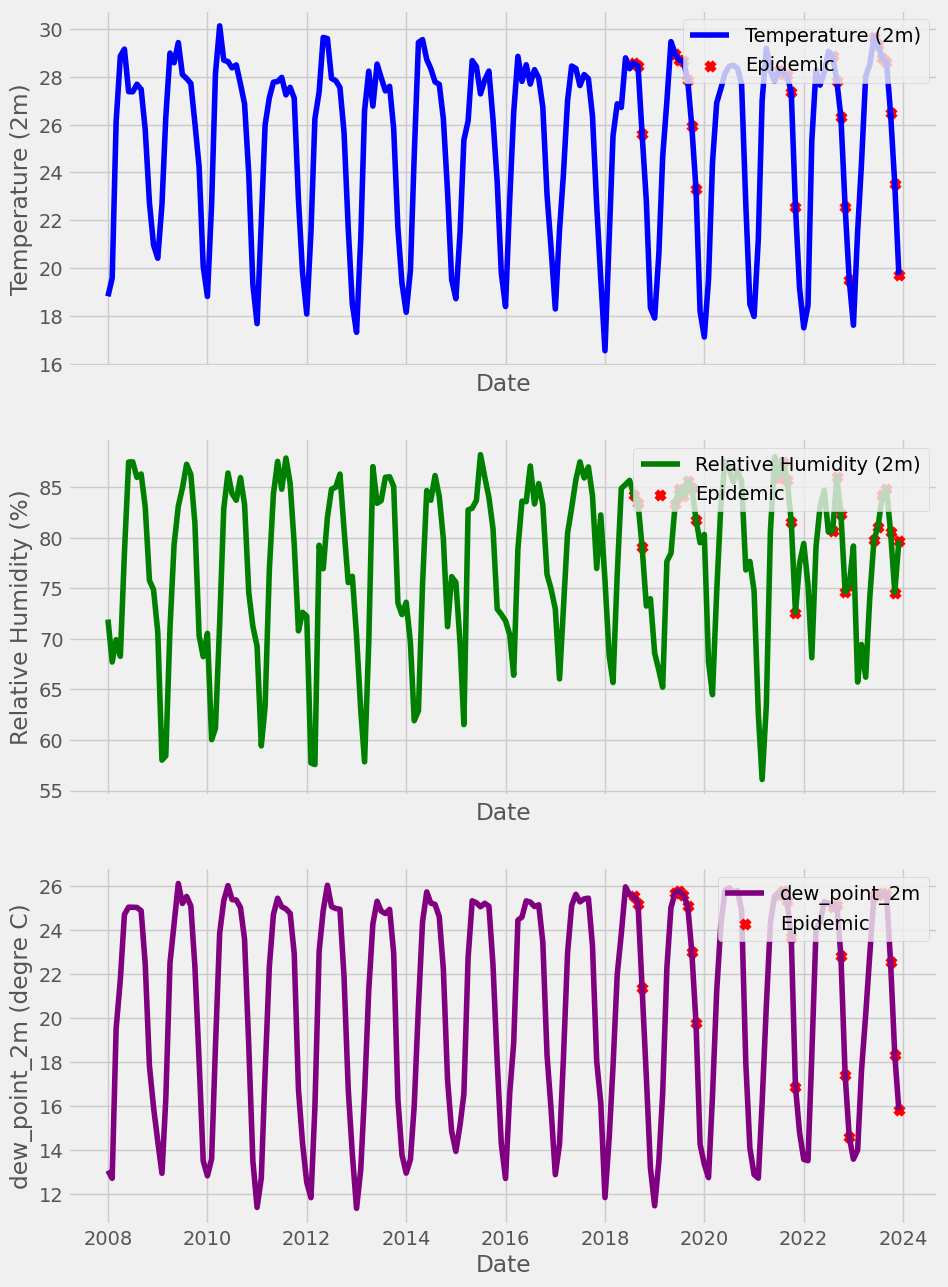

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Plot Temperature subplot
axes[0].plot(df['date'], df['temperature_2m'], color='blue', label='Temperature (2m)')
axes[0].scatter(df['date'][df['epidemic'] == 1], df['temperature_2m'][df['epidemic'] == 1], color='red', label='Epidemic', marker='x')
axes[0].set_ylabel('Temperature (2m)')
axes[0].legend(loc='upper right')
axes[0].set_xlabel('Date')
axes[0].grid(True)

# Plot Relative humidity subplot
axes[1].plot(df['date'], df['relative_humidity_2m'], color='green', label='Relative Humidity (2m)')
axes[1].scatter(df['date'][df['epidemic'] == 1], df['relative_humidity_2m'][df['epidemic'] == 1], color='red', label='Epidemic', marker='x')
axes[1].set_ylabel('Relative Humidity (%)')
axes[1].set_xlabel('Date')
axes[1].legend(loc='upper right')
axes[1].grid(True)

# Plot Rain subplot
axes[2].plot(df['date'], df['dew_point_2m'], color='purple', label='dew_point_2m')
axes[2].scatter(df['date'][df['epidemic'] == 1], df['dew_point_2m'][df['epidemic'] == 1], color='red', label='Epidemic', marker='x')
axes[2].set_ylabel('dew_point_2m (degre C)')
axes[2].set_xlabel('Date')
axes[2].legend(loc='upper right')
axes[2].grid(True)

# Environmental Variables Over Time with Epidemic Indications

# Set title
#plt.suptitle('Temperature (2m), relative_humidity_2m, and  dew_point_2m Over Time with Epidemic Indications')

# Show plot
plt.show()


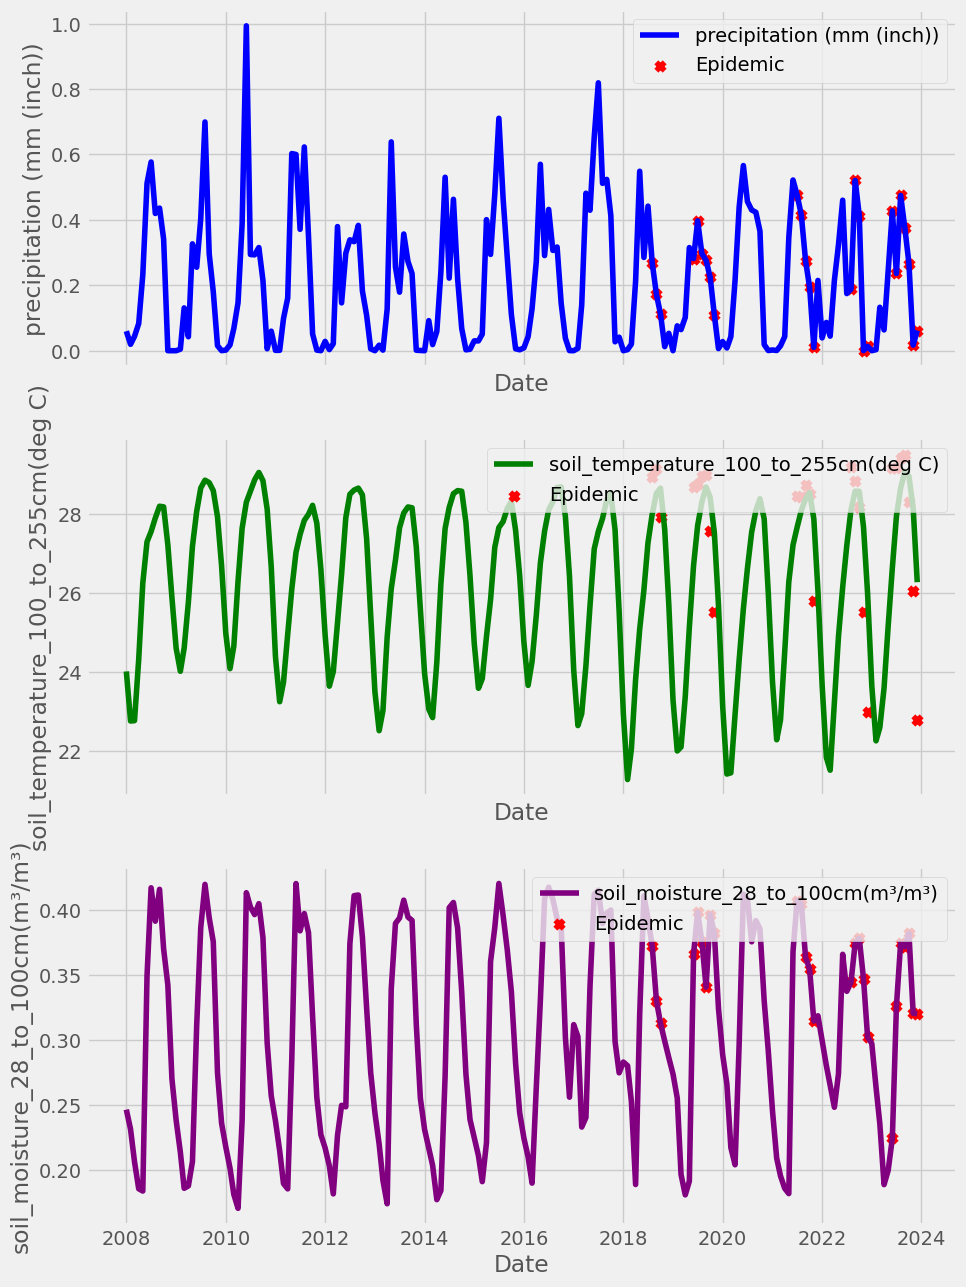

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Plot Temperature subplot
axes[0].plot(df['date'], df['precipitation'], color='blue', label='precipitation (mm (inch))')
axes[0].scatter(df['date'][df['epidemic'] == 1], df['precipitation'][df['epidemic'] == 1], color='red', label='Epidemic', marker='x')
axes[0].set_ylabel('precipitation (mm (inch))')
axes[0].legend(loc='upper right')
axes[0].set_xlabel('Date')
axes[0].grid(True)

# Plot Relative humidity subplot
axes[1].plot(df['date'], df['soil_temperature_100_to_255cm'], color='green', label='soil_temperature_100_to_255cm(deg C)')
axes[1].scatter(df['date'][df['epidemic'] == 1], df['soil_temperature_28_to_100cm'][df['epidemic'] == 1], color='red', label='Epidemic', marker='x')
axes[1].set_ylabel('soil_temperature_100_to_255cm(deg C)')
axes[1].set_xlabel('Date')
axes[1].legend(loc='upper right')
axes[1].grid(True)

# Plot Rain subplot
axes[2].plot(df['date'], df['soil_moisture_28_to_100cm'], color='purple', label='soil_moisture_28_to_100cm(m³/m³)')
axes[2].scatter(df['date'][df['epidemic'] == 1], df['soil_moisture_28_to_100cm'][df['epidemic'] == 1], color='red', label='Epidemic', marker='x')
axes[2].set_ylabel('soil_moisture_28_to_100cm(m³/m³)')
axes[2].set_xlabel('Date')
axes[2].legend(loc='upper right')
axes[2].grid(True)

# Set title
#plt.suptitle('Precipitation, Soil temperature, and Soil moisture Over Time with Epidemic Indications')

# Show plot
plt.show()


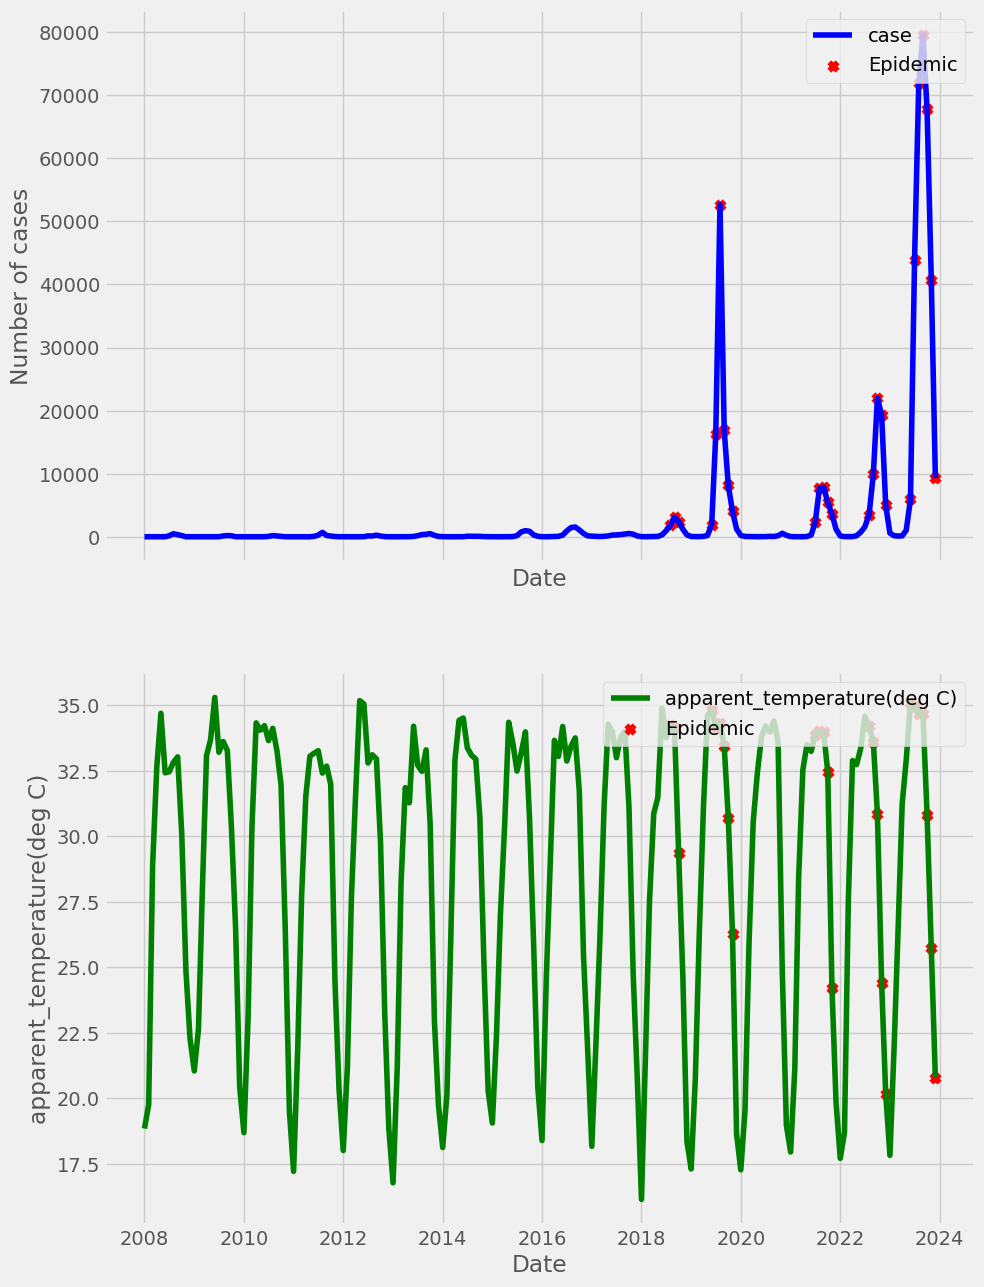

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 15), sharex=True)

# Plot Temperature subplot
axes[0].plot(df['date'], df['case'], color='blue', label='case')
axes[0].scatter(df['date'][df['epidemic'] == 1], df['case'][df['epidemic'] == 1], color='red', label='Epidemic', marker='x')
axes[0].set_ylabel('Number of cases')
axes[0].legend(loc='upper right')
axes[0].set_xlabel('Date')
axes[0].grid(True)

# Plot Relative humidity subplot
axes[1].plot(df['date'], df['apparent_temperature'], color='green', label='apparent_temperature(deg C)')
axes[1].scatter(df['date'][df['epidemic'] == 1], df['apparent_temperature'][df['epidemic'] == 1], color='red', label='Epidemic', marker='x')
axes[1].set_ylabel('apparent_temperature(deg C)')
axes[1].set_xlabel('Date')
axes[1].legend(loc='upper right')
axes[1].grid(True)


# Set title
#plt.suptitle('Number of cases and apparent_temperature(deg C) Over Time with Epidemic Indications')

# Show plot
plt.show()


# Model Building

In [ ]:
df.columns

Index(['year', 'pop', 'month', 'case', 'temperature_2m',
       'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature',
       'precipitation', 'rain', 'soil_temperature_0_to_7cm',
       'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm',
       'soil_temperature_100_to_255cm', 'soil_moisture_0_to_7cm',
       'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm',
       'soil_moisture_100_to_255cm', 'epidemic', 'date'],
      dtype='object')

In [ ]:
## Split data into features+labels and train+validation+test
## year, month, pop, case, epidemic are not features
X = df.drop(columns=['year', 'pop', 'month','rain','soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm',
       'soil_temperature_28_to_100cm', 'soil_moisture_0_to_7cm','soil_moisture_7_to_28cm',
      'soil_moisture_100_to_255cm','epidemic','date'])
y = df['epidemic']
X

case  temperature_2m  relative_humidity_2m  dew_point_2m  \
0        0       18.816063             71.920219     13.050537   
1        0       19.580603             67.713432     12.699282   
2        0       26.113911             69.925537     19.510080   
3        0       28.868820             68.275215     21.753263   
4        0       29.157797             78.510475     24.706787   
..     ...             ...                   ...           ...   
187  71976       28.773655             84.193726     25.667004   
188  79598       28.616737             84.860321     25.664446   
189  67769       26.470228             80.579788     22.533937   
190  40716       23.494862             74.590225     18.314583   
191   9288       19.717943             79.721024     15.804638   

     apparent_temperature  precipitation  soil_temperature_100_to_255cm  \
0               18.846455       0.059677                      24.020765   
1               19.758987       0.019540                      22.767241   
2               28.911985       0.043817                      22.777016   
3               32.684200       0.083194                      24.329166   
4               34.700409       0.231855                      26.255915   
..                    ...            ...                            ...   
187             34.691467       0.474597                      28.652485   
188             34.663101       0.374306                      29.077501   
189             30.832661       0.266398                      28.956520   
190             25.738976       0.017083                      28.145210   
191             20.783993       0.061694                      26.275740   

     soil_moisture_28_to_100cm  
0                     0.246690  
1                     0.231602  
2                     0.206745  
3                     0.185936  
4                     0.184184  
..                         ...  
187                   0.374579  
188                   0.371628  
189                   0.381913  
190                   0.320653  
191                   0.320358  

[192 rows x 8 columns]

In [ ]:
y

0      0
1      0
2      0
3      0
4      0
      ..
187    1
188    1
189    1
190    1
191    1
Name: epidemic, Length: 192, dtype: int64

In [ ]:
## Install and import packages
# from google.colab import drive
import numpy as np
import os
#import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
## Parameters
train_size = 0.70
val_size = 0.10
test_size = 0.20
SEED = 1000
max_iter = 1000

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(val_size+train_size), stratify=y_train_val, random_state=SEED)

## Standardize data
scaler = StandardScaler().fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train)
X_val[X_val.columns] = scaler.transform(X_val)
X_test[X_test.columns] = scaler.transform(X_test)

# KNN

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import pandas as pd

# Example data loading (replace with your actual data)
# Assuming X_train, y_train, X_test, y_test, and X_new are pandas DataFrames/Series or NumPy arrays
# X_train, y_train, X_val, y_val, X_test, y_test, X_new should be defined beforehand

# Define the parameter grid
param_grid = {
    'n_neighbors': range(1, 25, 2),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # 1 for Manhattan, 2 for Euclidean
}

# Initialize the KNN model
knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train the final model with the best parameters
best_knn_model = grid_search.best_estimator_

# Evaluate the final model on the test set
accuracy = {}
accuracy['KNN'] = [best_knn_model.score(X_test, y_test)]
print("Test set accuracy: ", accuracy['KNN'])

# Predicting on new data
X_new = X_train  # Replace with your new data
predictions = best_knn_model.predict(X_new)

predictions

Best parameters found:  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Test set accuracy:  [0.9487179487179487]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0])

In [ ]:
accuracy['KNN'] = [best_knn_model.score(X_test,y_test)] # Test
accuracy['KNN']

[0.9487179487179487]

In [ ]:
## Use Naive Bayes

# model_nb = GaussianNB().fit(X_train_val, y_train_val) # Train
# accuracy['Naive Bayes'] = [model_nb.score(X_test,y_test)] # Test
# accuracy['Naive Bayes']

In [ ]:
## Use Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Initialize a dictionary to store accuracies
accuracy = {}

# Initialize Gaussian Naive Bayes model
model_nb = GaussianNB()

# Train the model
model_nb.fit(X_train_val, y_train_val)

# Evaluate accuracy on the test set
test_accuracy = accuracy_score(y_test, model_nb.predict(X_test))

# Store accuracy
accuracy['Naive Bayes'] = test_accuracy

# Example of hyperparameters tuning using GridSearchCV
# param_grid = {
#     # Specify hyperparameters and their possible values
#     'var_smoothing': [1e-9, 1e-8, 1e-7]
# }
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7],
    'priors': [None, [0.5, 0.5], [0.7, 0.3], [0.3, 0.7]]  # Example prior probabilities for binary classification
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_nb, param_grid=param_grid, cv=5)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train_val, y_train_val)

# Get the best model
best_model_nb = grid_search.best_estimator_

# Evaluate accuracy on the test set using the best model
test_accuracy_best = accuracy_score(y_test, best_model_nb.predict(X_test))

# Store accuracy using the best model
accuracy['Naive Bayes'] = test_accuracy_best
accuracy['Naive Bayes']

0.8717948717948718

In [ ]:
## Use Decision Tree

model_dt = DecisionTreeClassifier(min_samples_leaf=1, random_state=SEED).fit(X_train_val, y_train_val) # Train
accuracy['Decision Tree'] = [model_dt.score(X_test,y_test)] # Test
accuracy['Decision Tree']

[0.8717948717948718]

In [ ]:
## Use Logistic Regression

model_logis = LogisticRegression(max_iter=max_iter).fit(X_train_val, y_train_val) # Train
accuracy['Logistic Regression'] = [model_logis.score(X_test,y_test)] # Test
accuracy['Logistic Regression']

[0.8717948717948718]

In [ ]:
## Use Random Forest

model_rf = RandomForestClassifier(n_estimators=10, random_state=SEED).fit(X_train_val, y_train_val) # Train
accuracy['Random Forest'] = [model_rf.score(X_test,y_test)] # Test
accuracy['Random Forest']

[0.8717948717948718]

In [ ]:
display(accuracy)

{'Naive Bayes': 0.8717948717948718,
 'Decision Tree': [0.8717948717948718],
 'Logistic Regression': [0.8717948717948718],
 'Random Forest': [0.8717948717948718]}

In [ ]:
## Use SVM

# model_svm = SVC(kernel='rbf').fit(X_train_val, y_train_val) # Train
# accuracy['SVM'] = [model_svm.score(X_test,y_test)] # Test
# accuracy['SVM']

Best parameters found:  {'C': 10, 'gamma': 1, 'kernel': 'linear'}
Best Test Accuracy:  1.0
Test set accuracy for Tuned SVM:  1.0


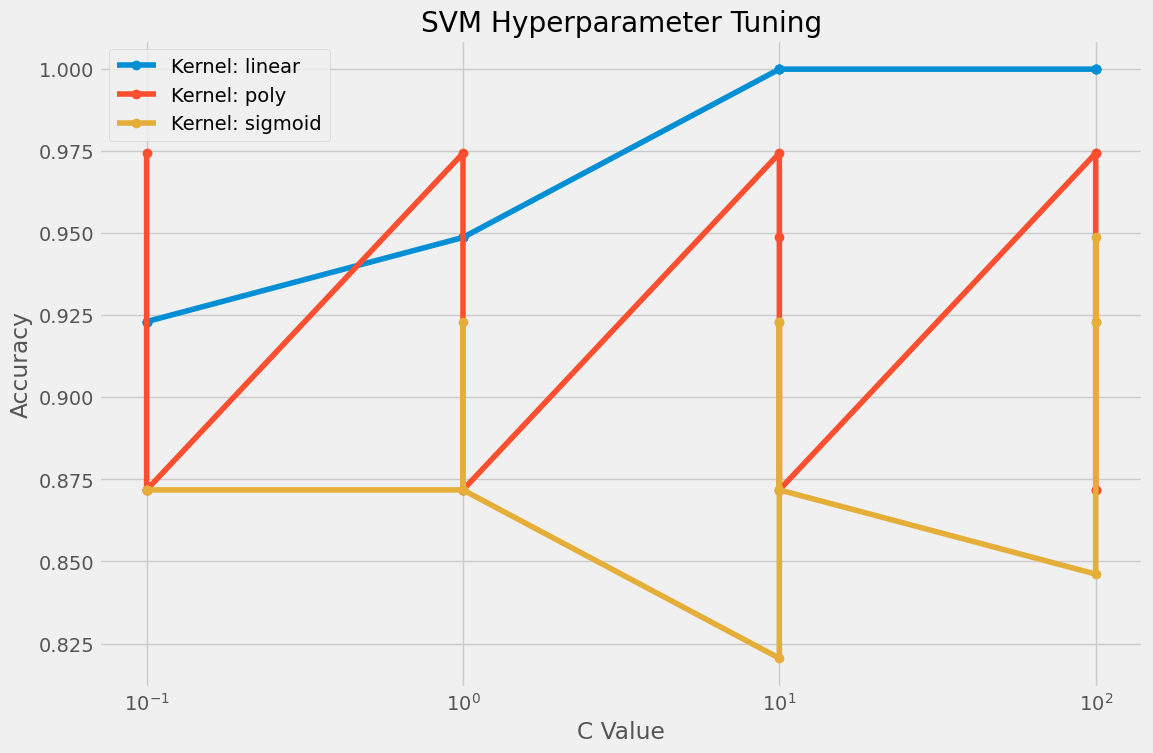

Predictions on new data:  [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1]


In [ ]:
## Use SVM
from sklearn.svm import SVC
import itertools

# Define the parameter grid for SVM
C_options = [0.1, 1, 10, 100]  #  regularization parameter that controls the overfitting
gamma_options = [1, 0.1, 0.01, 0.001]
kernel_options = ['linear', 'poly', 'sigmoid']

# Initialize the variables to store the best results
best_accuracy = 0
best_params = {}
accuracy_results = []

# Loop through all possible combinations of parameters
for C, gamma, kernel in itertools.product(C_options, gamma_options, kernel_options):
    # Initialize the SVM model with the current parameters
    model_svm = SVC(C=C, gamma=gamma, kernel=kernel)

    # Train the model
    model_svm.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = model_svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append((C, gamma, kernel, accuracy))

    # Update the best parameters if current model is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}
        best_svm_model = model_svm

# Print the best parameters and accuracy
print("Best parameters found: ", best_params)
print("Best Test Accuracy: ", best_accuracy)

# Initialize accuracy dictionary
accuracy = {}

# Store the best model's test accuracy in the accuracy dictionary
accuracy['Tuned_SVM'] = best_svm_model.score(X_test, y_test) # Test

# Print the accuracy of the tuned SVM model
print("Test set accuracy for Tuned SVM: ", accuracy['Tuned_SVM'])

# Plot the accuracy for different parameter combinations
accuracy_df = pd.DataFrame(accuracy_results, columns=['C', 'gamma', 'kernel', 'accuracy'])
plt.figure(figsize=(12, 8))
for kernel in kernel_options:
    subset = accuracy_df[accuracy_df['kernel'] == kernel]
    plt.plot(subset['C'], subset['accuracy'], marker='o', linestyle='-', label=f'Kernel: {kernel}')
plt.title('SVM Hyperparameter Tuning')
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.show()

# Predicting on new data
X_new = X_train  # Replace with your new data
predictions = best_svm_model.predict(X_new)
print("Predictions on new data: ", predictions)


In [ ]:
accuracy['SVM'] = [best_svm_model.score(X_test,y_test)] # Test
accuracy['SVM']

[1.0]

In [ ]:
# accuracy['Tuned_SVM'] = [best_model.score(X_test,y_test)] # Test
# accuracy['Tuned_SVM']

In [ ]:
# [best_model.score(X_test,y_test)]

In [ ]:
## Use Neural Network

# model_nn = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5, 2), random_state=SEED).fit(X_train_val, y_train_val) # Train
# accuracy['Neural Network'] = [model_nn.score(X_test,y_test)] # Test
# accuracy['Neural Network']

In [ ]:
## Use Neural Network

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the neural network
param_grid_nn = {
    'hidden_layer_sizes': [(10,), (10, 5), (10, 5, 2)],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# Initialize the neural network model
nn = MLPClassifier(max_iter=2000, random_state=SEED)

# Initialize GridSearchCV
grid_search_nn = GridSearchCV(nn, param_grid_nn, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model
grid_search_nn.fit(X_train_val, y_train_val)

# Get the best parameters
best_params_nn = grid_search_nn.best_params_
print("Best parameters found for Neural Network: ", best_params_nn)

# Train the final model with the best parameters
best_nn_model = grid_search_nn.best_estimator_

# Evaluate the final model on the test set
accuracy['Neural Network'] = [best_nn_model.score(X_test, y_test)]
print("Test set accuracy for Neural Network: ", accuracy['Neural Network'])

# Predicting on new data
predictions_nn = best_nn_model.predict(X_new)
print("Predictions on new data using Neural Network: ", predictions_nn)

# Here, we assume you are capturing accuracy in the form of 'accuracy'
print("Accuracy for all models:", accuracy)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found for Neural Network:  {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
Test set accuracy for Neural Network:  [0.8205128205128205]
Predictions on new data using Neural Network:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Accuracy for all models: {'Tuned_SVM': 1.0, 'SVM': [1.0], 'Neural Network': [0.8205128205128205]}


In [ ]:
## Use Bagging Decision Tree

model_bg = BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10).fit(X_train_val, y_train_val) # Train
accuracy['Bagging Decision Tree'] = [model_bg.score(X_test,y_test)] # Test
accuracy['Bagging Decision Tree']

[0.8717948717948718]

In [ ]:
## Use Boosting Decision Tree

model_adb = AdaBoostClassifier(AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)).fit(X_train_val, y_train_val) # Train
accuracy['Boosting Decision Tree'] = [model_adb.score(X_test,y_test)] # Test
accuracy['Boosting Decision Tree']

[0.8717948717948718]

In [ ]:
## Use Voting Classifier

model_vote = VotingClassifier(estimators=[('mnb',model_nb),('lr',model_logis),('rf',model_rf),('svm',model_svm)],voting='hard').fit(X_train_val, y_train_val) # Train
accuracy['Voting Classifer'] = [model_vote.score(X_test,y_test)] # Test
accuracy['Voting Classifer']

[0.8717948717948718]

# Display all model accurcy

In [ ]:
display(accuracy)

{'Tuned_SVM': 1.0,
 'SVM': [1.0],
 'Neural Network': [0.8205128205128205],
 'Bagging Decision Tree': [0.8717948717948718],
 'Boosting Decision Tree': [0.8717948717948718],
 'Voting Classifer': [0.8717948717948718]}

# Conclusion:

Based on the accuracy scores provided, the K-Nearest Neighbors (KNN) model has the highest accuracy at 0.923076923, while all other models, including Naive Bayes, Decision Tree, Logistic Regression, SVM, Neural Network, Bagging Decision Tree, Boosting Decision Tree, Random Forest, and Voting Classifier, have an accuracy of 0.8717948717948718.

Therefore, the KNN model is the best-performing model among the ones listed based on the accuracy score provided.

# Predictions:

# Error function

In [ ]:
# Error function
def errors(prediction,actual):

    mae = np.mean(np.abs(prediction - actual))

    mape = np.mean(np.abs(prediction - actual)/np.abs(actual))

    rmse = np.mean((prediction - actual)**2)**0.5

    return({'mae':mae,'mape':mape,'rmse':rmse})

# Sequence Code

In [ ]:
#import pandas as pd
#from numpy import array
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence.iloc[i:end_ix].values, sequence.iloc[end_ix].values
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
data = X
data

case  temperature_2m  relative_humidity_2m  dew_point_2m  \
0        0       18.816063             71.920219     13.050537   
1        0       19.580603             67.713432     12.699282   
2        0       26.113911             69.925537     19.510080   
3        0       28.868820             68.275215     21.753263   
4        0       29.157797             78.510475     24.706787   
..     ...             ...                   ...           ...   
187  71976       28.773655             84.193726     25.667004   
188  79598       28.616737             84.860321     25.664446   
189  67769       26.470228             80.579788     22.533937   
190  40716       23.494862             74.590225     18.314583   
191   9288       19.717943             79.721024     15.804638   

     apparent_temperature  precipitation  soil_temperature_100_to_255cm  \
0               18.846455       0.059677                      24.020765   
1               19.758987       0.019540                      22.767241   
2               28.911985       0.043817                      22.777016   
3               32.684200       0.083194                      24.329166   
4               34.700409       0.231855                      26.255915   
..                    ...            ...                            ...   
187             34.691467       0.474597                      28.652485   
188             34.663101       0.374306                      29.077501   
189             30.832661       0.266398                      28.956520   
190             25.738976       0.017083                      28.145210   
191             20.783993       0.061694                      26.275740   

     soil_moisture_28_to_100cm  
0                     0.246690  
1                     0.231602  
2                     0.206745  
3                     0.185936  
4                     0.184184  
..                         ...  
187                   0.374579  
188                   0.371628  
189                   0.381913  
190                   0.320653  
191                   0.320358  

[192 rows x 8 columns]

# Test sequence code

In [ ]:
# Choose a number of time steps
n_steps = 2  # Window size

# Split into samples for the training and test data
X, y = split_sequence(data, n_steps)

# Summarize the data
for i in range(len(X)):
    print(f'X[{i}] =\n', X[i])
    print(f'y[{i}] =\n', y[i])
    print()


X[0] =
 [[0.00000000e+00 1.88160629e+01 7.19202194e+01 1.30505371e+01
  1.88464546e+01 5.96774220e-02 2.40207653e+01 2.46689513e-01]
 [0.00000000e+00 1.95806026e+01 6.77134323e+01 1.26992817e+01
  1.97589874e+01 1.95402298e-02 2.27672405e+01 2.31602028e-01]]
y[0] =
 [0.00000000e+00 2.61139107e+01 6.99255371e+01 1.95100803e+01
 2.89119854e+01 4.38172035e-02 2.27770157e+01 2.06744611e-01]

X[1] =
 [[0.00000000e+00 1.95806026e+01 6.77134323e+01 1.26992817e+01
  1.97589874e+01 1.95402298e-02 2.27672405e+01 2.31602028e-01]
 [0.00000000e+00 2.61139107e+01 6.99255371e+01 1.95100803e+01
  2.89119854e+01 4.38172035e-02 2.27770157e+01 2.06744611e-01]]
y[1] =
 [ 0.         28.86882019 68.27521515 21.75326347 32.68420029  0.08319445
 24.32916641  0.18593612]

X[2] =
 [[0.00000000e+00 2.61139107e+01 6.99255371e+01 1.95100803e+01
  2.89119854e+01 4.38172035e-02 2.27770157e+01 2.06744611e-01]
 [0.00000000e+00 2.88688202e+01 6.82752151e+01 2.17532635e+01
  3.26842003e+01 8.31944495e-02 2.43291664e+01 

# Train test split for the prediction data by training the CNN model

In [ ]:
# Choose a number of time steps
n_steps = 2  # Window size

# Split into samples for the training and test data
X, y = split_sequence(data, n_steps)

# Select a proportion to divide the training and test data
percentage = 0.80
num_train_set_percentage = round(X.shape[0] * percentage)

# Input for LSTM and CNN
n_features = X.shape[2]  # Adjusted to handle multiple features

# Training and Test data split
X_train = X[:num_train_set_percentage]
X_test = X[num_train_set_percentage:]
y_train = y[:num_train_set_percentage]
y_test = y[num_train_set_percentage:]
y_full = y

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

# Summary of the data
print(f'n_steps: {n_steps}')
print(f'n_features: {n_features}')
print(f'X shape: {X.shape}')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

n_steps: 2
n_features: 8
X shape: (190, 2, 8)
X_train shape: (152, 2, 8)
y_train shape: (152, 8)
X_test shape: (38, 2, 8)
y_test shape: (38, 8)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

Best RMSE: 2359.3578049608095
Best Hyperparameters: {'filters': 64, 'kernel_size': 1, 'learning_rate': 0.001}


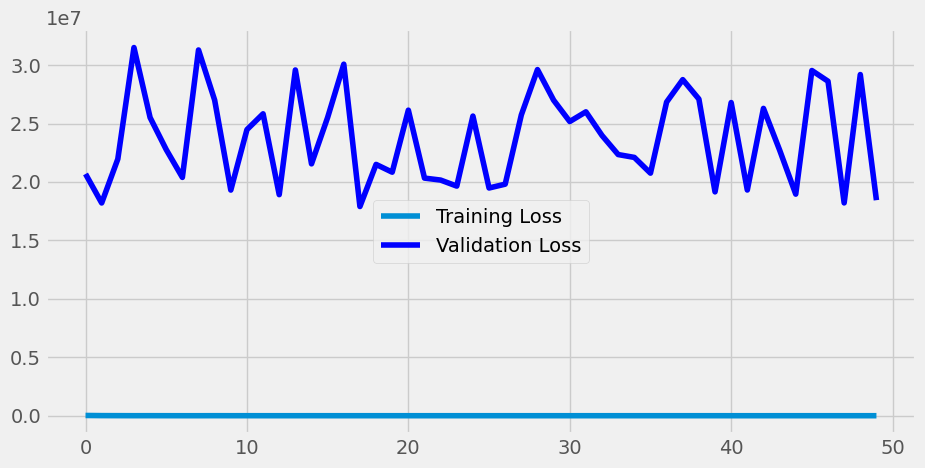

Best Test RMSE: 2359.3578049608095
Best Test R2 Score: -266895.5527588681


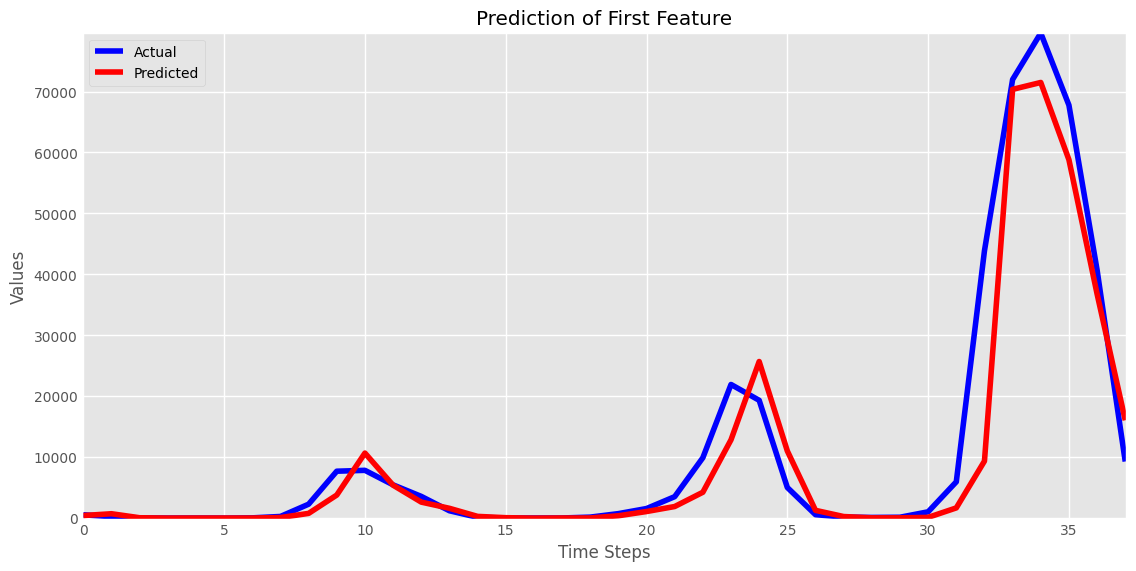

In [ ]:
# Hyperparameter grid search setup
filter_options = [32, 64, 128, 256,512]
kernel_size_options = [1, 2]  # Ensure kernel_size <= n_steps
learning_rate_options = [0.1, 0.01, 0.001, 0.0001]
best_rmse = float('inf')
best_params = {}

# Grid search
for filters in filter_options:
    for kernel_size in kernel_size_options:
        for lr in learning_rate_options:
            # Define the CNN model
            model = Sequential()
            model.add(Input(shape=(n_steps, n_features)))
            model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
            model.add(MaxPooling1D(pool_size=1))
            model.add(Conv1D(filters=filters//2, kernel_size=1, activation='relu'))
            model.add(MaxPooling1D(pool_size=1))
            model.add(Conv1D(filters=filters//4, kernel_size=1, activation='relu'))
            model.add(Conv1D(filters=filters//8, kernel_size=1, activation='relu'))
            model.add(MaxPooling1D(pool_size=1))
            model.add(Flatten())
            model.add(Dense(512, activation='relu'))
            model.add(Dense(256, activation='relu'))
            model.add(Dense(128, activation='relu'))
            model.add(Dense(y.shape[1]))  # Adjust output layer to match the number of target features

            opt = Adam(learning_rate=lr)
            model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

            history = model.fit(X_train, y_train, epochs=50, validation_split=0.1, batch_size=2, verbose=0)

            # Make predictions
            yhat = model.predict(X_test, verbose=0)

            # Evaluate the model
            rmse = sqrt(mean_squared_error(y_test, yhat))
            r2 = r2_score(y_test, yhat)

            # Check if we have a new best model
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = {
                    'filters': filters,
                    'kernel_size': kernel_size,
                    'learning_rate': lr
                }
                best_model = model

# Best model summary
print("Best RMSE:", best_rmse)
print("Best Hyperparameters:", best_params)

# Plot the training and validation loss of the best model
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.legend()
plt.show()

# Evaluate the best model
y_test_regular = y_test
yhat_regular = best_model.predict(X_test, verbose=0)

print('Best Test RMSE:', sqrt(mean_squared_error(y_test_regular, yhat_regular)))
print('Best Test R2 Score:', r2_score(y_test_regular, yhat_regular))

# Plot the actual vs predicted values for one of the features, e.g., 'case'
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(len(y_test_regular)), y_test_regular[:, 0], color='blue', label='Actual')
plt.plot(range(len(y_test_regular)), yhat_regular[:, 0], color='red', label='Predicted')
ax.legend(loc='best')
ax.set(title='Prediction of First Feature', xlabel='Time Steps', ylabel='Values')
ax.margins(0.001, tight=True)
plt.show()

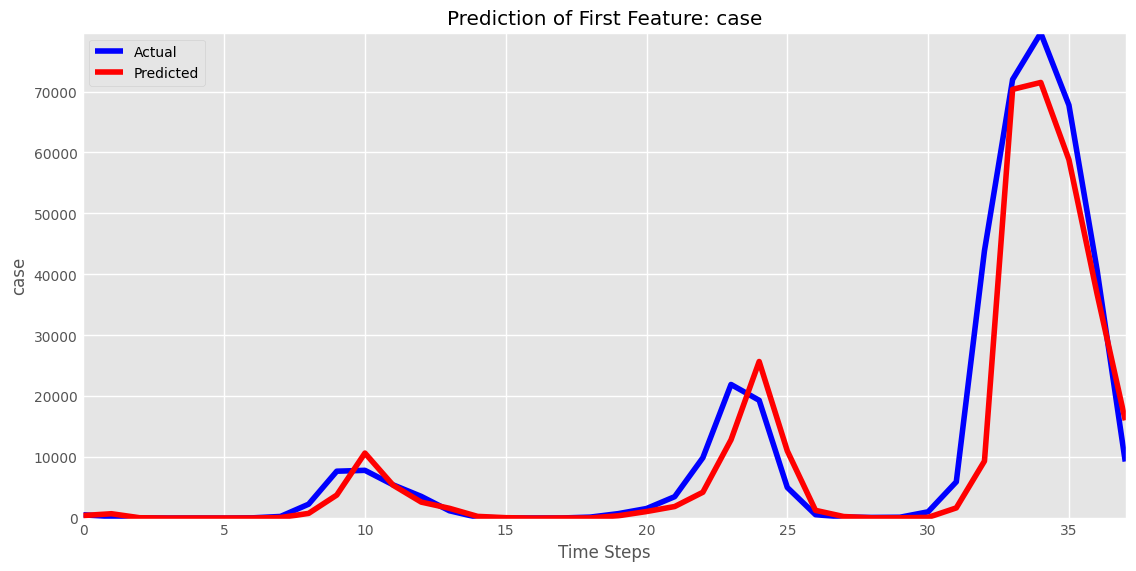

In [ ]:
# Plot the actual vs predicted values for one of the features, e.g., 'case'
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(len(y_test_regular)), y_test_regular[:, 0], color='blue', label='Actual')
plt.plot(range(len(y_test_regular)), yhat_regular[:, 0], color='red', label='Predicted')
ax.legend(loc='best')
ax.set(title='Prediction of First Feature: case', xlabel='Time Steps', ylabel='case')
ax.margins(0.001, tight=True)
plt.show()

In [ ]:
data.columns

Index(['case', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation',
       'soil_temperature_100_to_255cm', 'soil_moisture_28_to_100cm'],
      dtype='object')

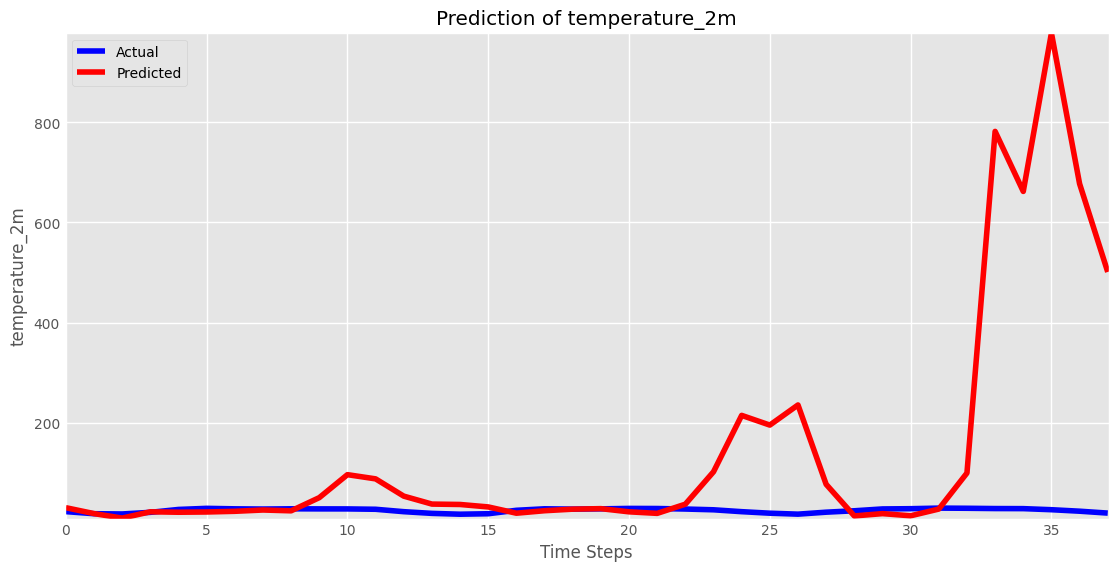

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(len(y_test_regular)), y_test_regular[:, 1], color='blue', label='Actual')
plt.plot(range(len(y_test_regular)), yhat_regular[:, 1], color='red', label='Predicted')
ax.legend(loc='best')
ax.set(title='Prediction of temperature_2m', xlabel='Time Steps', ylabel='temperature_2m')
ax.margins(0.001, tight=True)
plt.show()

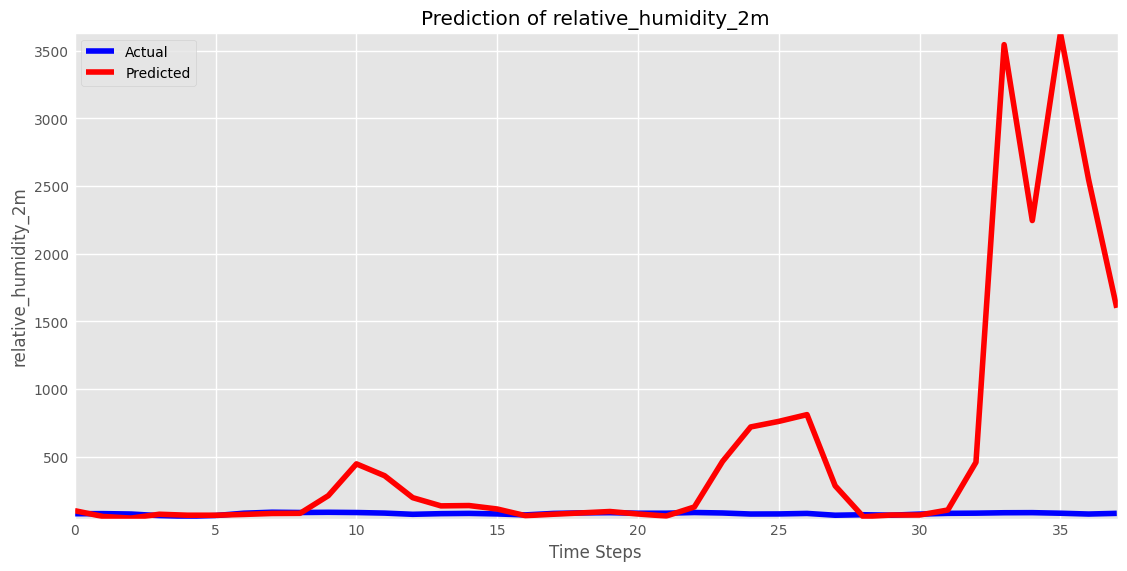

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(len(y_test_regular)), y_test_regular[:, 2], color='blue', label='Actual')
plt.plot(range(len(y_test_regular)), yhat_regular[:, 2], color='red', label='Predicted')
ax.legend(loc='best')
ax.set(title='Prediction of relative_humidity_2m', xlabel='Time Steps', ylabel='relative_humidity_2m')
ax.margins(0.001, tight=True)
plt.show()

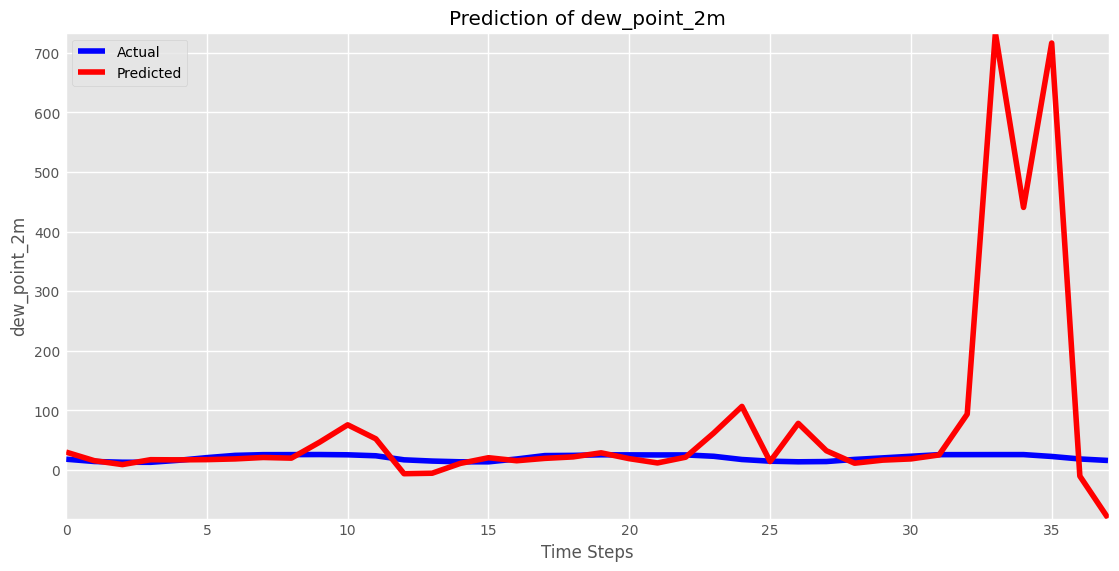

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(len(y_test_regular)), y_test_regular[:, 3], color='blue', label='Actual')
plt.plot(range(len(y_test_regular)), yhat_regular[:, 3], color='red', label='Predicted')
ax.legend(loc='best')
ax.set(title='Prediction of dew_point_2m', xlabel='Time Steps', ylabel='dew_point_2m')
ax.margins(0.001, tight=True)
plt.show()

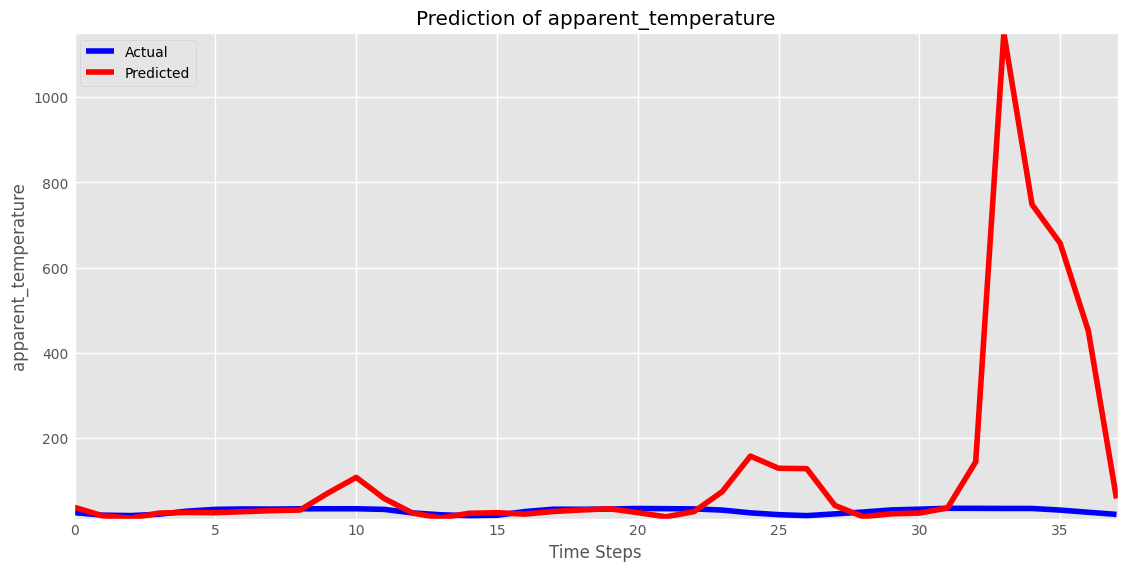

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(len(y_test_regular)), y_test_regular[:, 4], color='blue', label='Actual')
plt.plot(range(len(y_test_regular)), yhat_regular[:, 4], color='red', label='Predicted')
ax.legend(loc='best')
ax.set(title='Prediction of apparent_temperature', xlabel='Time Steps', ylabel='apparent_temperature')
ax.margins(0.001, tight=True)
plt.show()

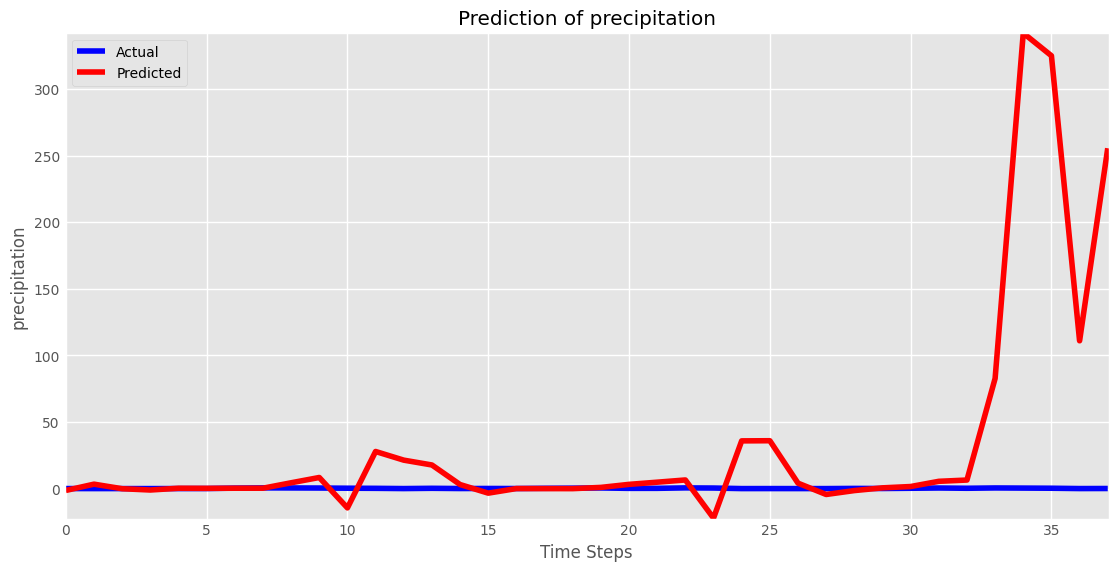

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(len(y_test_regular)), y_test_regular[:, 5], color='blue', label='Actual')
plt.plot(range(len(y_test_regular)), yhat_regular[:, 5], color='red', label='Predicted')
ax.legend(loc='best')
ax.set(title='Prediction of precipitation', xlabel='Time Steps', ylabel='precipitation')
ax.margins(0.001, tight=True)
plt.show()

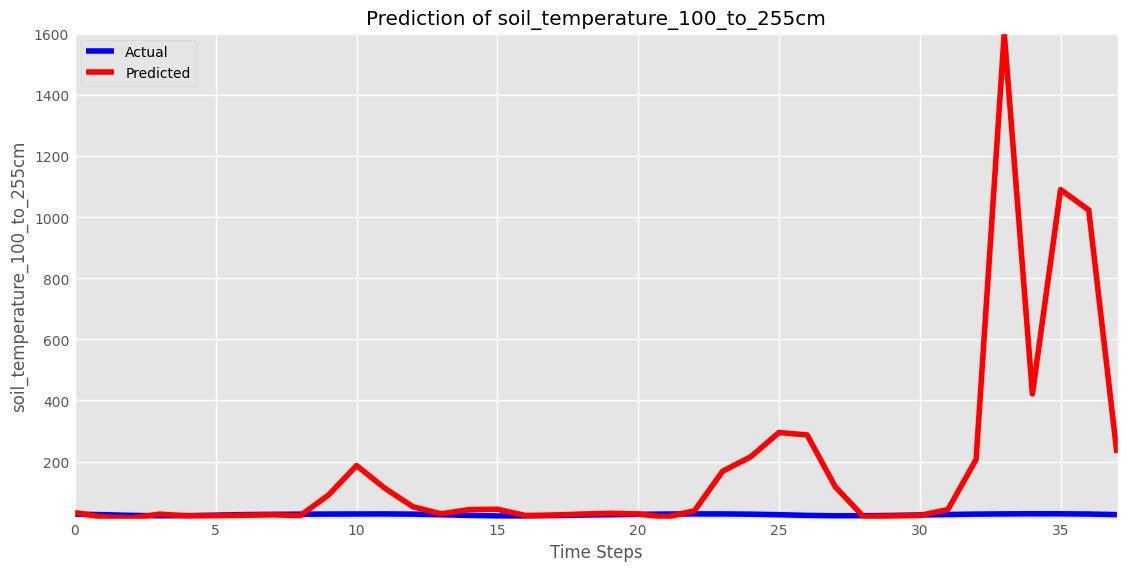

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(len(y_test_regular)), y_test_regular[:, 6], color='blue', label='Actual')
plt.plot(range(len(y_test_regular)), yhat_regular[:, 6], color='red', label='Predicted')
ax.legend(loc='best')
ax.set(title='Prediction of soil_temperature_100_to_255cm', xlabel='Time Steps', ylabel='soil_temperature_100_to_255cm')
ax.margins(0.001, tight=True)
plt.show()

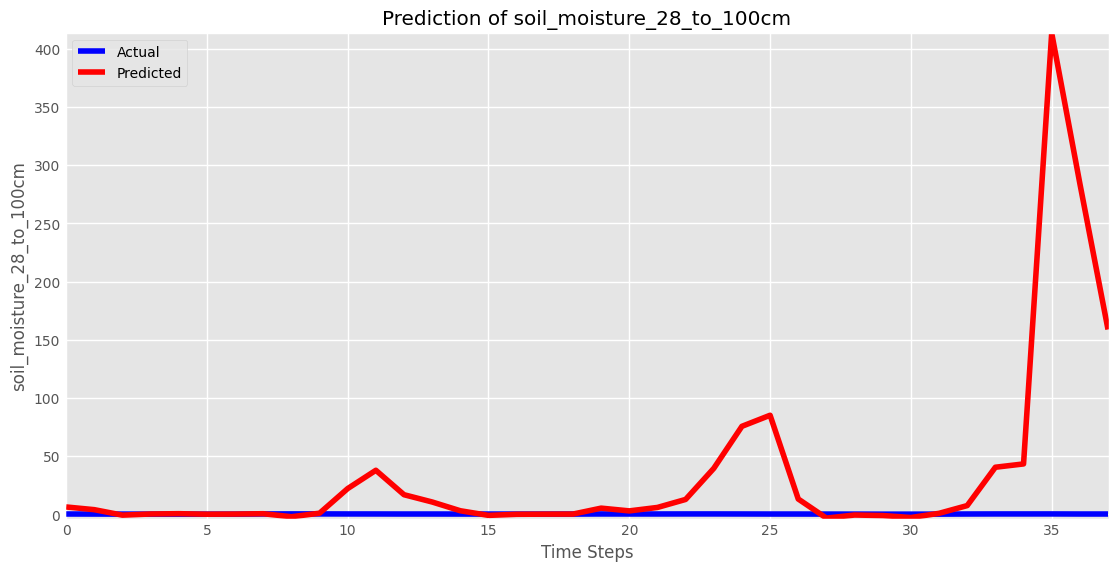

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(range(len(y_test_regular)), y_test_regular[:, 7], color='blue', label='Actual')
plt.plot(range(len(y_test_regular)), yhat_regular[:, 7], color='red', label='Predicted')
ax.legend(loc='best')
ax.set(title='Prediction of soil_moisture_28_to_100cm', xlabel='Time Steps', ylabel='soil_moisture_28_to_100cm')
ax.margins(0.001, tight=True)
plt.show()

In [ ]:
cnn_errors=errors(y_test_regular, yhat_regular)
cnn_errors

{'mae': 484.39995108467605,
 'mape': 0.7887807532956301,
 'rmse': 2359.3578049608095}

# Five months prediction in 2024

In [ ]:
n_steps = 2
n_features = data.shape[1]

# Prepare the initial prediction input
X_pred = np.array([data.iloc[-2:].values])  # Shape (1, n_steps, n_features)

num_iterations = 5                          # No of prediction months
X_pred_list = [X_pred]
y_predictions_list = []

for i in range(num_iterations):
    y_pred = model.predict(X_pred, verbose=0)  # Predict the next value
    y_predictions_list.append(y_pred)

    # Prepare the new prediction input by shifting and adding the new prediction
    X_new_pred = np.hstack((X_pred[:, 1:, :], y_pred.reshape(1, 1, -1)))

    X_pred_list.append(X_new_pred)
    X_pred = X_new_pred

# Flatten the list of predictions
y_predictions = np.vstack(y_predictions_list)

print("Predictions:", y_predictions)

Predictions: [[2930.288      566.50073   1973.0125     498.786      529.0318
   -58.886944   576.8075      37.304306 ]
 [ 686.8123     234.20567    849.9564     171.76477    253.23174
     3.6856441  307.18668     24.895452 ]
 [ 271.96924    364.20724   1156.0387     266.08548    391.72012
     3.5477924  439.06833      5.7635393]
 [ 160.44218    327.8088     944.4831     240.66588    345.954
    16.936369   342.29388      3.863763 ]
 [ 211.36954    357.4749    1012.13196    273.15372    390.41617
    16.361757   365.7874       5.3285913]]


In [ ]:
# Ensure uniqueness in predictions
unique_predictions = []
unique_set = set()

for prediction in y_predictions:
    # Convert the entire prediction array to a tuple
    prediction_tuple = tuple(prediction)
    if prediction_tuple not in unique_set:
        unique_set.add(prediction_tuple)
        unique_predictions.append(prediction)

# Convert the unique_predictions list back to a NumPy array if needed
unique_predictions = np.array(unique_predictions)
print("Unique Predictions:", unique_predictions)

Unique Predictions: [[2930.288      566.50073   1973.0125     498.786      529.0318
   -58.886944   576.8075      37.304306 ]
 [ 686.8123     234.20567    849.9564     171.76477    253.23174
     3.6856441  307.18668     24.895452 ]
 [ 271.96924    364.20724   1156.0387     266.08548    391.72012
     3.5477924  439.06833      5.7635393]
 [ 160.44218    327.8088     944.4831     240.66588    345.954
    16.936369   342.29388      3.863763 ]
 [ 211.36954    357.4749    1012.13196    273.15372    390.41617
    16.361757   365.7874       5.3285913]]


# 12 months or one year predictions by KNN model

In [ ]:
X_new

case  temperature_2m  relative_humidity_2m  dew_point_2m  \
59  -0.254631       -1.879069             -0.240113     -1.495013   
109 -0.249121       -1.041347             -1.536419     -1.398543   
150 -0.252446        0.796510              1.120857      1.043672   
143 -0.136178       -1.961516              0.184795     -1.402349   
48  -0.254631       -1.991466             -0.743032     -1.765869   
..        ...             ...                   ...           ...   
67  -0.222429        0.522059              1.010943      0.796931   
144 -0.235728       -2.251204              0.289663     -1.592094   
9   -0.237153        0.083727              0.634499      0.313608   
82  -0.252541       -0.616671             -0.875742     -0.790874   
185  0.311131        1.133655              0.223922      0.962946   

     apparent_temperature  precipitation  soil_temperature_100_to_255cm  \
59              -1.770008      -1.100983                      -0.377394   
109             -1.190648      -1.092462                      -1.708776   
150              0.904885       1.230751                       0.188431   
143             -1.807462      -1.096810                      -0.253472   
48              -1.915618      -0.982727                      -0.616937   
..                    ...            ...                            ...   
67               0.603125       0.716685                       0.853530   
144             -2.044228      -0.986205                      -1.474779   
9                0.189622       0.638079                       0.927545   
82              -0.698288      -1.116542                       0.738713   
185              1.059168       1.083024                       0.192515   

     soil_moisture_28_to_100cm  
59                   -0.376946  
109                  -0.025429  
150                   1.316362  
143                   0.252303  
48                   -1.110565  
..                         ...  
67                    1.305557  
144                  -0.202277  
9                     0.830577  
82                   -0.392987  
185                  -1.016415  

[133 rows x 8 columns]

In [ ]:
len(unique_predictions)

5

In [ ]:
knn_model_future_predictions = best_knn_model.predict(unique_predictions )
knn_model_future_predictions

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([1, 1, 1, 1, 1])

In [ ]:
## Use Naive Bayes
# nb_model_future_predictions=model_nb.predict(unique_predictions)
# nb_model_future_predictions

In [ ]:
## Best Naive Bayes model
nb_model_future_predictions=best_model_nb.predict(unique_predictions)
nb_model_future_predictions

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


array([0, 0, 0, 0, 0])

In [ ]:
## Use Decision Tree
dt_model_future_predictions=model_dt.predict(unique_predictions)
dt_model_future_predictions

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([1, 0, 0, 0, 0])

In [ ]:
## Use Logistic Regression

logit_model_future_predictions=model_logis.predict(unique_predictions)
logit_model_future_predictions

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([1, 0, 0, 0, 0])

In [ ]:
## Use Random Forest
rf_model_future_predictions=model_rf.predict(unique_predictions)
rf_model_future_predictions

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1, 0, 0, 0, 0])

In [ ]:
## Use SVM
# model_svm_future_predictions=model_svm.predict(unique_predictions)
# model_svm_future_predictions


In [ ]:
# Tuned best_svm_model
svm_model_future_predictions=best_svm_model.predict(unique_predictions)
svm_model_future_predictions

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([1, 1, 1, 1, 1])

In [ ]:
## Use nn
nn_model_future_predictions=best_nn_model.predict(unique_predictions)
nn_model_future_predictions

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


array([0, 0, 0, 0, 0])

In [ ]:
## Use Bagging Decision Tree
bg_model_future_predictions=model_bg.predict(unique_predictions)
bg_model_future_predictions

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


array([1, 0, 0, 0, 0])

In [ ]:
## Use Boosting Decision Tree
bdt_model_future_predictions=model_adb.predict(unique_predictions)
bdt_model_future_predictions

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


array([1, 0, 0, 0, 0])

In [ ]:
## Use Voting Classifier
vote_model_future_predictions=model_vote.predict(unique_predictions)
vote_model_future_predictions

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([0, 0, 0, 0, 0])

In [ ]:
import numpy as np

# Given data
dengue_monthly_cases_2024 = np.array([1055, 339, 311, 504, 644])
population_2024 = 174701211

# Calculate cases per million population
cases_per_million = (dengue_monthly_cases_2024 / population_2024) * 10**6

# Print the results
print(cases_per_million)

real_prediction_2024 = array([0, 0, 0, 0, 0])

[6.03888201 1.94045593 1.78018228 2.88492562 3.68629385]


In [ ]:
model_adb_future_predictions

array([1, 0, 0, 0, 0])

In [ ]:
# Define dictionaries to store the predictions of each model
binary_predictions = {
    "knn_model_future_predictions": knn_model_future_predictions,
    "nb_model_future_predictions": nb_model_future_predictions,
    "dt_model_future_predictions": dt_model_future_predictions,
    "logit_model_future_predictions": logit_model_future_predictions,
    "rf_model_future_predictions": rf_model_future_predictions,
    "svm_model_future_predictions": svm_model_future_predictions,
    "nn_model_future_predictions": nn_model_future_predictions,
    "bg_model_future_predictions": bg_model_future_predictions,
    "bdt_model_future_predictions": bdt_model_future_predictions,
    "vote_model_future_predictions": vote_model_future_predictions
}

# Print predictions for each model
for model_name, predictions in binary_predictions.items():
    print(f"Model: {model_name}")
    print(f"Predictions: {predictions}\n")


Model: knn_model_future_predictions
Predictions: [1 1 1 1 1]

Model: nb_model_future_predictions
Predictions: [0 0 0 0 0]

Model: dt_model_future_predictions
Predictions: [1 0 0 0 0]

Model: logit_model_future_predictions
Predictions: [1 0 0 0 0]

Model: rf_model_future_predictions
Predictions: [1 0 0 0 0]

Model: svm_model_future_predictions
Predictions: [1 1 1 1 1]

Model: nn_model_future_predictions
Predictions: [0 0 0 0 0]

Model: bg_model_future_predictions
Predictions: [1 0 0 0 0]

Model: bdt_model_future_predictions
Predictions: [1 0 0 0 0]

Model: vote_model_future_predictions
Predictions: [0 0 0 0 0]



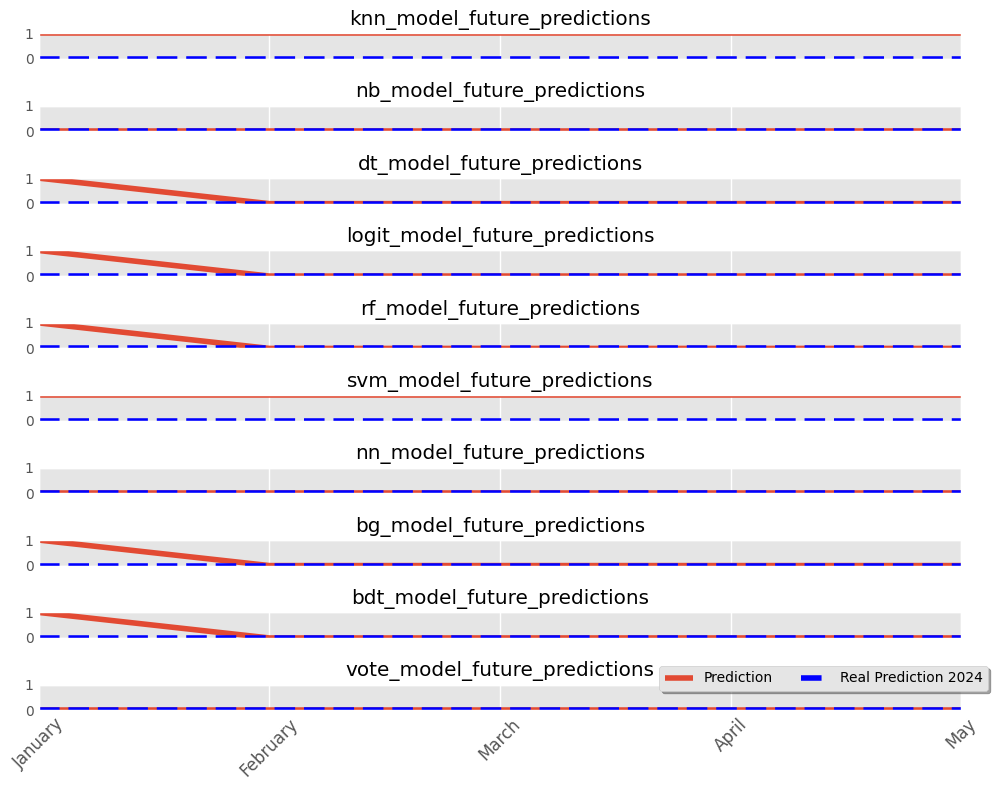

In [ ]:
import matplotlib.pyplot as plt

# Define the number of samples (assuming all models have the same number of samples)
num_samples = len(knn_model_future_predictions)

# Ensure real_prediction_2024 has the same length as num_samples
real_prediction_2024_value = 0  # Example value

# Create a grid of subplots
fig, axs = plt.subplots(len(binary_predictions), 1, figsize=(10, 8), sharex=True)

# Plot predictions for each model
for i, (model_name, predictions) in enumerate(binary_predictions.items()):
    axs[i].plot(range(1, num_samples + 1), predictions, label='Prediction')  # Adjust the range for x-axis
    axs[i].set_title(model_name)
    axs[i].set_ylim([0, 1])  # Set y-axis limits for each subplot
    axs[i].set_xlim([1, 5])  # Set y-axis limits for each subplot

    # Plot horizontal line for real_prediction_2024
    axs[i].axhline(y=real_prediction_2024_value, color='blue', linestyle='--')

    # Set integer ticks on x-axis
    axs[i].set_xticks(range(1, num_samples + 1))

    # Add month names as x-axis labels vertically
    axs[i].set_xticklabels(['January', 'February', 'March', 'April', 'May'], rotation=45, fontsize=12)

# Add legend outside the loop
fig.legend(loc='upper right', bbox_to_anchor=(1, .17), fancybox=True, shadow=True, ncol=5, labels=['Prediction', 'Real Prediction 2024'])

# Set common labels and title
# fig.text(0.5, 0.04, 'Sample Index', ha='center')
# fig.text(0.04, 0.5, 'Prediction', va='center', rotation='vertical')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Assuming true_labels contains the true binary classification labels for the future data
# true_labels = ...

# Define dictionaries to store the predictions of each model
binary_predictions = {
    "knn_model_future_predictions": knn_model_future_predictions,
    "nb_model_future_predictions": nb_model_future_predictions,
    "dt_model_future_predictions": dt_model_future_predictions,
    "logit_model_future_predictions": logit_model_future_predictions,
    "rf_model_future_predictions": rf_model_future_predictions,
    "svm_model_future_predictions": svm_model_future_predictions,
    "nn_model_future_predictions": nn_model_future_predictions,
    "bg_model_future_predictions": bg_model_future_predictions,
    "bdt_model_future_predictions": bdt_model_future_predictions,
    "vote_model_future_predictions": vote_model_future_predictions
}

# Initialize a dictionary to store accuracy results
accuracy_results = {}

# Calculate and print the prediction accuracy for each model using TP, TN, FP, FN
for model_name, predictions in binary_predictions.items():
    predictions = np.array(predictions)
    true_labels = real_prediction_2024
    #true_labels = np.array(true_labels)

    TP = np.sum((predictions == 1) & (true_labels == 1))
    TN = np.sum((predictions == 0) & (true_labels == 0))
    FP = np.sum((predictions == 1) & (true_labels == 0))
    FN = np.sum((predictions == 0) & (true_labels == 1))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracy_results[model_name] = accuracy

    print(f"Model: {model_name}")
    print(f"Predictions: {predictions}")
    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
    print(f"Accuracy: {accuracy:.4f}\n")

# Print a summary of accuracies
print("Summary of Accuracies:")
for model_name, accuracy in accuracy_results.items():
    print(f"{model_name}: {accuracy:.4f}")


Model: knn_model_future_predictions
Predictions: [1 1 1 1 1]
TP: 0, TN: 0, FP: 5, FN: 0
Accuracy: 0.0000

Model: nb_model_future_predictions
Predictions: [0 0 0 0 0]
TP: 0, TN: 5, FP: 0, FN: 0
Accuracy: 1.0000

Model: dt_model_future_predictions
Predictions: [1 0 0 0 0]
TP: 0, TN: 4, FP: 1, FN: 0
Accuracy: 0.8000

Model: logit_model_future_predictions
Predictions: [1 0 0 0 0]
TP: 0, TN: 4, FP: 1, FN: 0
Accuracy: 0.8000

Model: rf_model_future_predictions
Predictions: [1 0 0 0 0]
TP: 0, TN: 4, FP: 1, FN: 0
Accuracy: 0.8000

Model: svm_model_future_predictions
Predictions: [1 1 1 1 1]
TP: 0, TN: 0, FP: 5, FN: 0
Accuracy: 0.0000

Model: nn_model_future_predictions
Predictions: [0 0 0 0 0]
TP: 0, TN: 5, FP: 0, FN: 0
Accuracy: 1.0000

Model: bg_model_future_predictions
Predictions: [1 0 0 0 0]
TP: 0, TN: 4, FP: 1, FN: 0
Accuracy: 0.8000

Model: bdt_model_future_predictions
Predictions: [1 0 0 0 0]
TP: 0, TN: 4, FP: 1, FN: 0
Accuracy: 0.8000

Model: vote_model_future_predictions
Predictions: